# **Fake News Detection using title and text**

This notebook detects the fake news based on the title and text of the article. The fake news detection is modelled using three algorithms to predict fake and real news and the sections covered in this notebook are:

1. Install libraries 
2. Import necessary libraries and load the data
3. Data Cleaning
4. Text Preprocessing
5. Function for Evaluation Metrics
6. Apply the algortihms to predict the fake news: 
      1. Decision Tree
      2. Gradient Boosting Tree Classifier
      3. Neural Network using Keras and Elephas
7. Conclusion


**1. Install Libraries**

This project is implemented using Apache Spark written in Pyspark. In order to code the project in jupyter notebook, Pyspark module should be installed which is done using the command !pip install pyspark.


In [1]:
!pip install pyspark

     |████████████████████████████████| 204.7MB 61kB/s 
     |████████████████████████████████| 204kB 44.0MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.0-py2.py3-none-any.whl size=205044182 sha256=abb3a9efbfc2ed2a11f65ed7053688ef5acfc3e42b92ee7c0a18b96909aadba1
  Stored in directory: /root/.cache/pip/wheels/57/27/4d/ddacf7143f8d5b76c45c61ee2e43d9f8492fc5a8e78ebd7d37
Successfully built pyspark


Elephas is an extension of Keras, which allows you to run distributed deep learning models at scale with Spark. To implement deep learning models, Elephas is installed which supports the following versions of Keras and Tensorflow. 

*   Keras: 2.2.4
*   TensorFlow: 1.14.0

Thus the above versions are installed and the runtime is restarted to use the new version.

In [2]:
!pip install q keras==2.2.4
!pip install q tensorflow==1.14.0

     |████████████████████████████████| 317kB 3.7MB/s 
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1
     |████████████████████████████████| 109.2MB 52kB/s 
     |████████████████████████████████| 491kB 27.5MB/s 
     |████████████████████████████████| 3.2MB 42.9MB/s 
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: tensorboard 2.2.2
    Uninstalling tensorboard-2.2.2:
      Successfully uninstalled tensorboard-2.2.2
  Found existing installation: tensorflow 2.2.0
    Uninstalling tensorflow-2.2.0:
      Successfully uninstalled tensorflow-2.2.0


In [5]:
import keras
import tensorflow

print(keras.__version__)
print(tensorflow.__version__)

2.2.4
1.14.0


Install elephas to integrate Keras with Apache Spark using !pip install elephas

In [4]:
!pip install elephas

The data for this project is taken from Kaggle: Fake and real news dataset. Steps to follow to download data from kaggle directly into jupyter notebook:

1. Install kaggle using pip command
2. Navigate to presonal kaggle account and click Create New API Token, a json file is downloaded into the system.
3. Upload the file into the notebook using file.upload command
4. Make a directory called Kaggle and copy the file into the directory. Change the permissions of the file using the below commands. 
       !mkdir -p ~/.kaggle
       !cp kaggle.json ~/.kaggle/
       !chmod 600 ~/.kaggle/kaggle.json
5. Navigate to the Kaggle dataset page and click on the 3 dots on the right hand side of the page. Click on Copy API command and paste in the notebook cell to download the data. It looks something as below:
        !kaggle datasets download -d clmentbisaillon/fake-and-real-news-dataset
6. Using unzip command, the data is unzipped and the files are chekced using !ls command.

In [6]:
from google.colab import files
#upload the kaggle.json file
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rashmigrp","key":"842c46e1bfdfcdb1a382cda3e783a72e"}'}

In [7]:
#make a directory and copy the json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

#change permission to 600: the owner has full read and write access to the file, while no other user can access the file
!chmod 600 ~/.kaggle/kaggle.json

In [8]:
#https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset
#download the data using Copy API command from the data page
!kaggle datasets download -d clmentbisaillon/fake-and-real-news-dataset

100% 41.0M/41.0M [00:00<00:00, 55.2MB/s]



In [9]:
#list the files present
!ls

fake-and-real-news-dataset.zip	kaggle.json  sample_data


In [10]:
#unzip the fake news data
!unzip \*.zip

Archive:  fake-and-real-news-dataset.zip
  inflating: Fake.csv                
  inflating: True.csv                


In [11]:
#check for the unzipped files
!ls

fake-and-real-news-dataset.zip	Fake.csv  kaggle.json  sample_data  True.csv


**2. Import statements and load the data**

**2.1 Import the libraries**

The necessary libraries and modules are imported. The main import statements are:

1. SparkContext: Main entry point for Spark functionality. A SparkContext represents the connection to a Spark cluster, and can be used to create RDD and broadcast variables on that cluster
2. SparkConf: For configuring Spark and Used to set various Spark parameters as key-value pairs
3. SQLContext: The entry point into all relational functionality in Spark is the SQLContext class. To create a basic SQLContext, all needed is a SparkContext.

In [12]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql import *
from pyspark.sql.functions import isnan, when, count, col, udf,  lower, regexp_replace, rand, round, lit, concat
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, StringIndexer, HashingTF, IDF, IndexToString, Word2Vec
from pyspark.sql.types import IntegerType
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics, BinaryClassificationMetrics
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras import optimizers, regularizers
from keras.optimizers import Adam
import keras
from elephas.spark_model import SparkModel
from elephas.ml_model import ElephasEstimator
import matplotlib.pyplot as plt
import numpy as np

WARNING


In [13]:
#create a SparkConf with the following attributes:
#setAppName: Set application name
#setMaster: Set master URL to connect to
#spark driver memory is a flag that controls the amount of memory to allocate for a driver, which is 1GB by default. It is
#set to 15g to accomadate the text processing and training of models
conf = SparkConf().setAppName('Fake_news_detection').setMaster('local[4]').set('spark.driver.memory', '15g')

#create an entry point using SparkConf: conf
sc = SparkContext(conf=conf)

#SQLcontext is created using sc for realational functionality
sql_context = SQLContext(sc)

#spark = SparkSession.builder.getOrCreate()

**2.2 Load the data**

The dataset is divided into two CSV files: Fake News and Real News. The two files are read individually and joined together to a single dataset. The target feature for Real data is set to True and Fake data is set to false. 

sql_context.read.csv is used to read the csv files

In [14]:
#read the real news data
true_data = sql_context.read.csv('True.csv', header = True, inferSchema = True)

New column: target is created using withColumn and lit() funcitons.

        withColumn: Returns a new DataFrame by adding a column or replacing the existing column that has the same name. 
        Parameters:	colName: string, name of the new column.
                       col: a Column expression for the new column.
        lit() function is used for column expression. It is a way for us to interact with column literals in PySpark

In [15]:
#create a new column "target" with values as True
true_data = true_data.withColumn("target", lit("True"))

#display the true news data
true_data.show(5)

+--------------------+--------------------+------------+------------------+------+
|               title|                text|     subject|              date|target|
+--------------------+--------------------+------------+------------------+------+
|As U.S. budget fi...|WASHINGTON (Reute...|politicsNews|December 31, 2017 |  True|
|U.S. military to ...|WASHINGTON (Reute...|politicsNews|December 29, 2017 |  True|
|Senior U.S. Repub...|WASHINGTON (Reute...|politicsNews|December 31, 2017 |  True|
|FBI Russia probe ...|WASHINGTON (Reute...|politicsNews|December 30, 2017 |  True|
|Trump wants Posta...|SEATTLE/WASHINGTO...|politicsNews|December 29, 2017 |  True|
+--------------------+--------------------+------------+------------------+------+
only showing top 5 rows



In [16]:
#check the length of the true data
true_data.count()

21417

In [17]:
#read the fake news data
fake_data = sql_context.read.csv('Fake.csv', header=True, inferSchema=True)

In [18]:
#create a new column "target" with values as Fake
fake_data = fake_data.withColumn("target", lit("Fake"))

#display the fake news data
fake_data.show(5)

+--------------------+--------------------+-------+-----------------+------+
|               title|                text|subject|             date|target|
+--------------------+--------------------+-------+-----------------+------+
| Donald Trump Sen...|Donald Trump just...|   News|December 31, 2017|  Fake|
| Drunk Bragging T...|House Intelligenc...|   News|December 31, 2017|  Fake|
| Sheriff David Cl...|On Friday, it was...|   News|December 30, 2017|  Fake|
| Trump Is So Obse...|On Christmas day,...|   News|December 29, 2017|  Fake|
| Pope Francis Jus...|Pope Francis used...|   News|December 25, 2017|  Fake|
+--------------------+--------------------+-------+-----------------+------+
only showing top 5 rows



In [19]:
#check the length of fake news 
fake_data.count()

23489

In [20]:
#concatanate fake and real news using union function 
data = true_data.union(fake_data)

In [21]:
#concate title and text column to create a new column news
data = data.withColumn('news',concat(col('title'),lit(' '), col('text')))

In [22]:
#shuffle the data
data = data.orderBy(rand())

In [23]:
#dispaly the combined data
data.show(5)

+--------------------+--------------------+------------+----------------+------+--------------------+
|               title|                text|     subject|            date|target|                news|
+--------------------+--------------------+------------+----------------+------+--------------------+
| Sean Hannity Dis...|Conspiracy-loving...|        News|    May 22, 2017|  Fake| Sean Hannity Dis...|
|TRUMP WOULD FEED ...|While Donald Trum...|    politics|    Sep 26, 2015|  Fake|TRUMP WOULD FEED ...|
|Illinois governor...|CHICAGO (Reuters)...|politicsNews|August 26, 2016 |  True|Illinois governor...|
| Republicans Puni...|Georgia conservat...|        News|  April 17, 2016|  Fake| Republicans Puni...|
|FIRE THIS WOMAN! ...| Please RT until ...|   left-news|     Feb 3, 2017|  Fake|FIRE THIS WOMAN! ...|
+--------------------+--------------------+------------+----------------+------+--------------------+
only showing top 5 rows



In [24]:
#check the length of combined data
print("The length of the data: " +str(data.count()))

The length of the data: 44906


**3. Data Cleaning**

Remove the null and NaN values from all the columns of the data

In [25]:
#remove title, subject and date columns
columns = ["title","text", "subject", "date"]
data = data.drop(*columns)

In [26]:
#drop the null values
data = data.na.drop()

In [27]:
#check for null values
data.select([count(when(isnan(c), c)).alias(c) for c in data.columns]).show()

+------+----+
|target|news|
+------+----+
|     0|   0|
+------+----+



In [28]:
#print the schema of the data
data.printSchema()

root
 |-- target: string (nullable = false)
 |-- news: string (nullable = true)



This shows all the columns of the data are string type and descriptive features columns can be null but the target feature cannot be null.

**4. Text Preprocessing**

The text preprocessing involves the following steps:

1. Tokenize the text into words using RegexTokenizer which is more advanced tokenization based on regular expression matching
2. Removal of Stopwords using StopWordsRemover. Default english stopwords are used to remove unwanted words from the data.
3. Converting text to numerical. Word2Vec is an Estimator which takes sequences of words representing documents, computes distributed vector representation of words and trains a Word2VecModel. The model maps each word to a unique fixed-size vector. The Word2VecModel transforms each document into a vector using the average of all words in the document. The advantage of this representations is that similar words are close in the vector space, which makes generalization to novel patterns easier and model estimation more robust.

4. Convert target categorical values into intergers using StringIndexer.  StringIndexer encodes a string column of labels to a column of label indices.


In [29]:
'''Tokenization'''
#set the Regextokenizer with pattern = \\W
tokenizer = RegexTokenizer(inputCol = "news", outputCol = "words", pattern = "\\W")

'''Stopwords removal'''
#load the default english stopwords
add_stopwords = StopWordsRemover.loadDefaultStopWords("english")

#create a stopwords functions for thw words column from the tokenizer
remover = StopWordsRemover(inputCol = "words", outputCol = "filtered").setStopWords(add_stopwords)
#remover.transform(tokenizer).show(truncate=False)

'''Word to vector'''
w2v = Word2Vec(vectorSize = 350, minCount = 0, inputCol = "filtered", outputCol = "features")

'''Label Indexer'''
#Convert the target feature categorical values into intergers
label_stringIdx = StringIndexer(inputCol = "target", outputCol = "label")

Next create a Pipelime for the above functions to be perfomed on the data. The stages of the Pipline are set as: tokenization, removal of stopwords, coverting words to vector using Word2vec and converting categorical values to intergers.

In [30]:
#pipleline for text pre-processing
pipeline = Pipeline(stages = [tokenizer, remover, w2v, label_stringIdx])

#fit the dat for the pipeline
pipelineFit = pipeline.fit(data)
dataset = pipelineFit.transform(data)

dataset.show(5)

+------+--------------------+--------------------+--------------------+--------------------+-----+
|target|                news|               words|            filtered|            features|label|
+------+--------------------+--------------------+--------------------+--------------------+-----+
|  Fake| Sean Hannity Dis...|[sean, hannity, d...|[sean, hannity, d...|[-0.0984267791070...|  0.0|
|  Fake|TRUMP WOULD FEED ...|[trump, would, fe...|[trump, feed, chi...|[-0.0302769050211...|  0.0|
|  True|Illinois governor...|[illinois, govern...|[illinois, govern...|[0.01869498767281...|  1.0|
|  Fake| Republicans Puni...|[republicans, pun...|[republicans, pun...|[-0.0119417001244...|  0.0|
|  Fake|FIRE THIS WOMAN! ...|[fire, this, woma...|[fire, woman, ran...|[-0.0847264165555...|  0.0|
+------+--------------------+--------------------+--------------------+--------------------+-----+
only showing top 5 rows



The data is converted to numerical format and below shows the schema of the preprocessed data.

In [31]:
#check the schema for preprocessed data
dataset.printSchema()

root
 |-- target: string (nullable = false)
 |-- news: string (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- features: vector (nullable = true)
 |-- label: double (nullable = false)



 **5. Function for Evaluation Metrics**

This project is implmented using three machine learning algorithms. The performance of the models are evaluated confusion matrix, F1 score and Area under the curve. The model with less False positives and false negatives, high F1 score and AUC will be considered as a better model for fake news detection. Matplotlib and Numpy is used to plot the confusion matrix. 

In [32]:
#function to calculate the evaluation metrics
def eval_metrics(predictions):
    '''Accuracy'''
    #label = predictions.select(['prediction', 'label'])
    evaluator = MulticlassClassificationEvaluator(labelCol = "label", predictionCol = "prediction", metricName = "accuracy")
    accuracy = evaluator.evaluate(predictions)*100

    #select prediction and label columns to calculate metric values
    results = predictions.select(['prediction', 'label'])
    #convert the results to rdd to get predictions and labels
    predictionAndLabels = results.rdd
  
    '''Area under the curve'''
    #binary_evaluator = BinaryClassificationEvaluator()
    #auc = binary_evaluator.evaluate(predictions, {binary_evaluator.metricName: "areaUnderROC"})
    binary_evaluator = BinaryClassificationMetrics(predictionAndLabels)
    auc = binary_evaluator.areaUnderROC

    '''Classification report'''
    #create a multiclassmetrics instance
    metrics = MulticlassMetrics(predictionAndLabels)

    #compute Recall with respect to Real and fake news data
    real_recall = metrics.recall(1.0)
    fake_recall = metrics.recall(0.0)

    #compute Precision with respect to Real and fake news data
    real_precision = metrics.precision(1.0)
    fake_precision = metrics.precision(0.0)

    #compute F1 Score with respect to Real and fake news data
    real_f1 = metrics.fMeasure(1.0)
    fake_f1 = metrics.fMeasure(0.0)

    #create a classificaiton report for the model
    real = Row(News = 'Real', recall = real_recall, precision = real_precision, f1_score = real_f1)
    fake = Row(News = 'Fake', recall = fake_recall, precision = fake_precision, f1_score = fake_f1) 
  
    classification_report = [real, fake]
    classification_report_df = sql_context.createDataFrame(classification_report)

    '''Confusion matrix'''
    conf_matrix = metrics.confusionMatrix().toArray()
  
    return accuracy, auc, classification_report_df, conf_matrix

In [33]:
#function for confusion matrix
def plot_confusion_matrix(cm, target_names, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()

    width, height = cm.shape

    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')
            
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

**6. Modelling**

This section implements different algorithms to predict the fake news. Initially the data is split into train and test in the ratio 80:20 using randomSplit function.

In [34]:
#split the data
train, test = dataset.randomSplit([0.8, 0.2])

In [35]:
#check the train and test data count
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 35843
Test Dataset Count: 9055


**6.1 Decision Tree**

A decision tree is a flowchart-like tree structure with internal node representing feature, the branch represents a decision rule, and each leaf node represents the outcome. The topmost node is known as the root node and the bottom nodes are leaf nodes. Decision trees are white box ML algorithms that can handle high dimensional data with good accuracy.

The decision trees selects the best feature to split at the root node based on Attribute Selection measures: Gini Index or Entropy. The measured values is calculated at every step before a node split till the required number of nodes are grown. The ASM used here is Gini Index. An attribute with higher Gini Index is considered for the split. Gini Index considers a binary split for each attribute using the below formula. 

$Gini(D) = 1 - \sum_{i=1}^m P_i^2$

Where, Pi is the probability that a tuple in D belongs to class Ci.

The decision parameters:

  1. labelCol: Label column name
  2. featureCol: features column name
  3. impurity: Gini index.  

In [36]:
from pyspark.ml.classification import DecisionTreeClassifier
#define decision tree
dt = DecisionTreeClassifier(labelCol="label", featuresCol = "features")

#train the model and predict on test data
dtModel = dt.fit(train)
dt_predictions = dtModel.transform(test)

In [37]:
#calculate the evaluation metrics of naive bayes model
dt_accuracy, dt_auc, dt_classification_report_df, dt_conf_matrix = eval_metrics(dt_predictions)

In [38]:
#print the auuracy and area under the curve
print("Decision Tree accuracy is: {:0.2f}".format(dt_accuracy))
print("Decision Tree AUC is: {:0.2f}".format(dt_auc))

Decision Tree accuracy is: 91.00
Decision Tree AUC is: 0.91


In [39]:
#display the classification report
dt_classification_report_df.show()

+----+------------------+------------------+------------------+
|News|            recall|         precision|          f1_score|
+----+------------------+------------------+------------------+
|Real|0.8952555581022232|0.9160412757973734|0.9055291526602528|
|Fake|0.9236999147485081|0.9046128156960969|0.9140567331013393|
+----+------------------+------------------+------------------+



In [40]:
#print the confusion matrix
print("Confusion Matrix")
print(dt_conf_matrix)

Confusion Matrix
[[4334.  358.]
 [ 457. 3906.]]


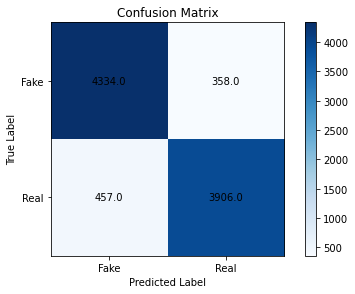

In [41]:
#plot confusion matrix
plot_confusion_matrix(dt_conf_matrix,["Fake","Real"])

**6.2 Gradient Bossting Tree Classifier**

Gradient Boosting classifiers consists of many weak classifiers that are combined together to make a strong model. The training of the models takes places sequentially and decision trees are mostly used as classfiers in Gradient boosting. Thus GBTs train one tree at a time and training is only parallelized at the single tree level.

The main aim of GBT is to minimize the loss of the model. The model trains on the wieghted dataset where all the instances in the data are assigned same weight initially and the classification is done for the first tree. For the next tree the wieghts are misclassified instances are increased while the weights of correctly classified instances are decreased. This process is continued till the loss function has reached it minimum. The loss function for text classification would be how well our model can classify the fake news. 

A 3-Fold cross validation is performed to tune the parameters of the RF classifier that are defined using ParamGridBuilder.The parameters tuned are:

  1. maxDepth: Maximum depth of the tree.
  2. minInstancesPerNode: Minimum number of instances each child must have after split.
  3. maxIter: Max number of iterations
  4. subsamplingRate: Fraction of the training data used for learning each decision tree. It is set to 0.75 where 75% percent of train data is used for training and 25% for validation
  5. stepSize: Step size (a.k.a. learning rate) in interval (0, 1] for shrinking the contribution of each estimator

In [42]:
#check the parameters of GBT classifier
gbt_classifier = GBTClassifier()
print(gbt_classifier.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 

In [43]:
#define the GBT classifier
gbt_classifier = GBTClassifier(labelCol = "label", featuresCol = "features")
              
#define the parameters for the GBT
gbt_paramGrid = (ParamGridBuilder()
             .addGrid(gbt_classifier.maxDepth, [4, 6])
             .addGrid(gbt_classifier.minInstancesPerNode, [2, 4])
             .addGrid(gbt_classifier.stepSize, [0.01])
             .addGrid(gbt_classifier.maxIter, [20,30])
             .addGrid(gbt_classifier.subsamplingRate, [0.75])
             .build())
#evaluator for CV
evaluator = BinaryClassificationEvaluator()

#perform 3-fold CV
gbt_cv = CrossValidator(estimator = gbt_classifier, estimatorParamMaps = gbt_paramGrid, evaluator = evaluator, numFolds = 3)
gbt_cvModel = gbt_cv.fit(train)
gbt_predictions = gbt_cvModel.transform(test)

In [44]:
#dispaly the best parameters after CV
gbt_best_parameters = gbt_cvModel.bestModel
print("Max Depth: " + str(gbt_best_parameters._java_obj.getMaxDepth()))
print("Min Instances Per Node: " + str(gbt_best_parameters._java_obj.getMinInstancesPerNode()))
print("Number of Trees: " + str(gbt_best_parameters._java_obj.getNumTrees()))

Max Depth: 6
Min Instances Per Node: 2
Number of Trees: 20


In [45]:
#compute the evaluation metrics using eval_metrics functions
gbt_classifier = GBTClassifier(labelCol = "label", featuresCol = "features",maxDepth = 6, minInstancesPerNode = 2, maxIter = 20, subsamplingRate = 0.75)

gbtModel = gbt_classifier.fit(train)
gbt_predictions = gbtModel.transform(test)

gbt_accuracy, gbt_auc, gbt_classification_report_df, gbt_conf_matrix = eval_metrics(gbt_predictions)

In [46]:
#print accuracy and AUC
print ('GBT accuracy is {:0.2f}'.format(gbt_accuracy))
print ('GBT AUC is {:0.2f}'.format(gbt_auc))

GBT accuracy is 93.79
GBT AUC is 0.94


In [47]:
#print classification report
gbt_classification_report_df.show()

+----+------------------+------------------+------------------+
|News|            recall|         precision|          f1_score|
+----+------------------+------------------+------------------+
|Real| 0.931239972495989|0.9394219653179191|0.9353130755064457|
|Fake|0.9441602728047741|0.9365750528541226|0.9403523668011037|
+----+------------------+------------------+------------------+



In [48]:
#print confusion matrix
print("Confusion Matrix")
print(gbt_conf_matrix)

Confusion Matrix
[[4430.  262.]
 [ 300. 4063.]]


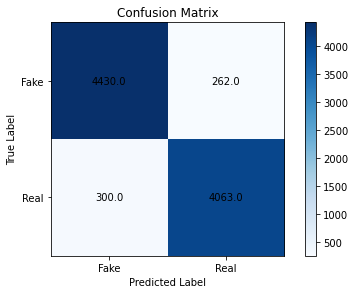

In [49]:
#plot confusion matrix
plot_confusion_matrix(gbt_conf_matrix, ["Fake","Real"])

**6.3 Neural Network using Keras and Elephas**

Elephas is an extension of Keras, which allows you to run distributed deep learning models at scale with Spark. Elephas implements a class of data-parallel algorithms on top of Keras, using Spark's RDDs and data frames. Keras Models are initialized on the driver, then serialized and shipped to workers, alongside with data and broadcasted model parameters. Spark workers deserialize the model, train their chunk of data and send their gradients back to the driver. The "master" model on the driver is updated by an optimizer, which takes gradients either synchronously or asynchronously. The working of elephas is as follows:
![alt text](https://raw.githubusercontent.com/maxpumperla/elephas/master/elephas.gif) 

The neural network model is defined using Keras layers and model is trained using the parameter defined in the elephas sparkML estimator. The neural network model consists:
  1. Of 1 input layer, 2 hidden layers and 1 output layer
  2. All layers are Dense layers with activation functions for input and hidden layers are ReLU and Softmax for outplut layer
  3. A dropout layer of 10% is used after each layer 
  4. Binary Cross entropy loss function and Adam optimizer with 0.01 learning rate and the metrics used is "accuracy"

In [53]:
from keras import layers

#count the number of target labels
tar_class = train.select("label").distinct().count()

#dimension of input data
input_dim = len(train.select("features").first()[0])

#define the neural network model
model = Sequential()
model.add(Dense(256, input_dim = input_dim, activation = "relu"))
model.add(Dropout(0.1))
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.1))
model.add(Dense(64, activation = "relu"))
model.add(Dense(tar_class, activation = "softmax"))

model.compile(optimizer = "adam",
              loss = 'binary_crossentropy',
               metrics=['accuracy'])

model.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 256)               89856     
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 130       
Total params: 131,138
Trainable params: 131,138


The parameters of the estimator are:

  1. set_keras_model_config(model.to_yaml()): Set the neural network model
  2. set_categorical_labels(True): Set to True if labels are categorical
  3. set_nb_classes(tar_class): Set the number of target classes
  4. set_num_workers(1): Set the number of worker nodes
  5. set_epochs(10): Set the number of iterations for the training
  6. set_batch_size(64): Set the batch size 
  7. set_verbosity(1): Set the verbosity for the results display
  8. set_validation_split(0.10): Set the validation data split from the training data
  9. set_optimizer_config(opt_conf): Set the defined optimizer
  10. set_mode("synchronous"): Set the mode to synchronous
  11. set_loss("binary_crossentropy"): Set the loss for the model same as keras model.compile loss
  12. set_metrics(["acc"]): Set the metrics for the model evaluation

In [54]:
#define the adam optimizer with lr = 0.01
optimizer_conf = optimizers.Adam(lr = 0.01)
opt_conf = optimizers.serialize(optimizer_conf)

#define elephas estimator
estimator = ElephasEstimator()

#set the parameters for the estimator
estimator.set_keras_model_config(model.to_yaml())
estimator.set_categorical_labels(True)
estimator.set_nb_classes(tar_class)
estimator.set_num_workers(1)
estimator.set_epochs(5)
estimator.set_batch_size(64)
estimator.set_verbosity(1)
estimator.set_validation_split(0.10)
estimator.set_optimizer_config(opt_conf)
estimator.set_mode("synchronous")
estimator.set_loss("binary_crossentropy")
estimator.set_metrics(["acc"])

ElephasEstimator_9c47b203ea40

In [55]:
#train the model using the estimator
fitted_pipeline = estimator.fit(train)

#Predict the test data
nn_prediction = fitted_pipeline.transform(test)

>>> Fit model
>>> Synchronous training complete.


In [56]:
#compute the evaluation metrics 
nn_accuracy, nn_auc, nn_classification_report, nn_conf_matrix = eval_metrics(nn_prediction)

In [57]:
#print accuracy and AUC
print ('Neural Network accuracy is {:0.2f}'.format(nn_accuracy))
print ('Neural Network AUC is {:0.2f}'.format(nn_auc))

Neural Network accuracy is 98.60
Neural Network AUC is 0.99


In [58]:
#print classification report
nn_classification_report.show()

+----+------------------+------------------+------------------+
|News|            recall|         precision|          f1_score|
+----+------------------+------------------+------------------+
|Real|0.9848727939491175|0.9860027535566773|0.9854374498337346|
|Fake| 0.986999147485081|0.9859484777517564|0.9864735328575993|
+----+------------------+------------------+------------------+



In [59]:
#print confusion matrix
print("Confusion Matrix")
print(nn_conf_matrix)

Confusion Matrix
[[4631.   61.]
 [  66. 4297.]]


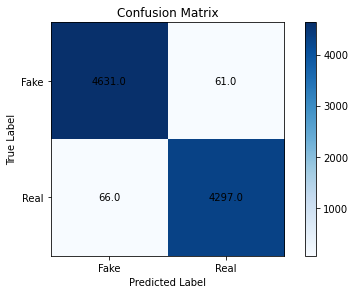

In [60]:
#plot confusion matrix
plot_confusion_matrix(nn_conf_matrix, ["Fake","Real"])

**7. Conclusion**

The dataset was trained using three algorithms and the model performance is studied using F1 score and confusion matrix. Below shows the table of the models performance:

| Model           | AUC | F1 score               | Accuracy |
|-----------------|-----|------------------------|----------|
|Decision Tree    |0.91 |Real:0.90<br>Fake: 0.91 |91.00%    |
|Gradient Boosting|0.94 |Real: 0.93<br>Fake: 0.94|93.79%    |
|Neural Network   |0.99 |Real: 0.98<br>Fake: 0.98|98.60%    |

The best model is Neural Network with and accuracy of 98% and less false positives and false negatives compared to Decision tree and Gradient Boosting.

References:

https://spark.apache.org/docs/latest/ml-guide.html

https://github.com/maxpumperla/elephas